## Importing Libraries

In [79]:
!pip install contractions

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [81]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import string
# import fasttext
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# plt.xticks(rotation=70)
# pd.options.mode.chained_assignment = None
# pd.set_option('display.max_colwidth', 100)
# %matplotlib inline

ModuleNotFoundError: No module named 'contractions'

## Loading the Dataset

In [21]:

# Specify the path to your JSON file
file_path = 'complaints-2021-05-14_08_16_.json'

# Open the JSON file
with open(file_path, 'r') as file:
    # Load the JSON data
    data = json.load(file)

# Convert the JSON data to a pandas DataFrame
df = pd.DataFrame(data)

# Now you can work with the DataFrame
# For example, you can access a specific field

In [22]:
data_ = pd.read_json('complaints-2021-05-14_08_16_.json')
dfs: pd.DataFrame = data_["_source"].apply(pd.Series)

In [23]:
dfs.head()

,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,Problem with rewards from credit card,Consent provided
3,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [25]:
selected_columns = ['complaint_id', 'issue', 'date_received', 'product', 'company_response', 'company', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']

# Create a new DataFrame with only the selected columns
dfs= dfs[selected_columns]

# View the first few rows of the new DataFrame
dfs.head()

,complaint_id,issue,date_received,product,company_response,company,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,Didn't receive enough information to verify debt,Consent provided
2,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,Problem with rewards from credit card,Consent provided
3,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Conventional home mortgage,Yes,,None,Consent not provided
4,3203545,Fees or interest,2019-04-05T12:00:00-05:00,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Sanity Checks

In [27]:
dfs.shape

(78313, 11)

In [28]:
dfs.isnull().sum()

complaint_id                     0
issue                            0
date_received                    0
product                          0
company_response                 0
company                          0
sub_product                  10571
timely                           0
complaint_what_happened          0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [29]:
null_values = dfs['product'].isnull().sum()

# Print the number of null values
print("Number of null values in the 'product' column:", null_values)

Number of null values in the 'product' column: 0


In [30]:
dfs['complaint_what_happened'].nunique()

20931

In [31]:
filtered_df = dfs[dfs['complaint_what_happened'] != '']

filtered_df

,complaint_id,issue,date_received,product,company_response,company,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,Didn't receive enough information to verify debt,Consent provided
2,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,Problem with rewards from credit card,Consent provided
10,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Other personal consumer report,Yes,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",Information belongs to someone else,Consent provided
11,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",Information belongs to someone else,Consent provided
14,3224980,Managing an account,2019-04-27T12:00:00-05:00,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Checking account,Yes,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,Funds not handled or disbursed as instructed,Consent provided
...,...,...,...,...,...,...,...,...,...,...,...
78303,3094545,"Advertising and marketing, including promotional offers",2018-12-07T12:00:00-05:00,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,General-purpose credit card or charge card,Yes,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for...",Didn't receive advertised or promotional terms,Consent provided
78309,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,Credit card or prepaid card,Closed with monetary relief,JPMORGAN CHASE & CO.,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to...",Other problem,Consent provided
78310,3133355,Problem with a lender or other company charging your account,2019-01-25T12:00:00-05:00,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Checking account,Yes,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...,Transaction was not authorized,Consent provided
78311,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,Credit card or prepaid card,Closed with monetary relief,JPMORGAN CHASE & CO.,General-purpose credit card or charge card,Yes,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica...",Problem with balance transfer,Consent provided


### Example of our Feature and Target VAriable

In [43]:
print('Complaint:', filtered_df['complaint_what_happened'][14])
print('\nProduct category for complaint:',filtered_df['product'][14])

Complaint: my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time  date happen XX/XX/2018 check number XXXX claim number is XXXX with chase

Product category for complaint: Checking or savings account


## Distrbution of our Target Variable

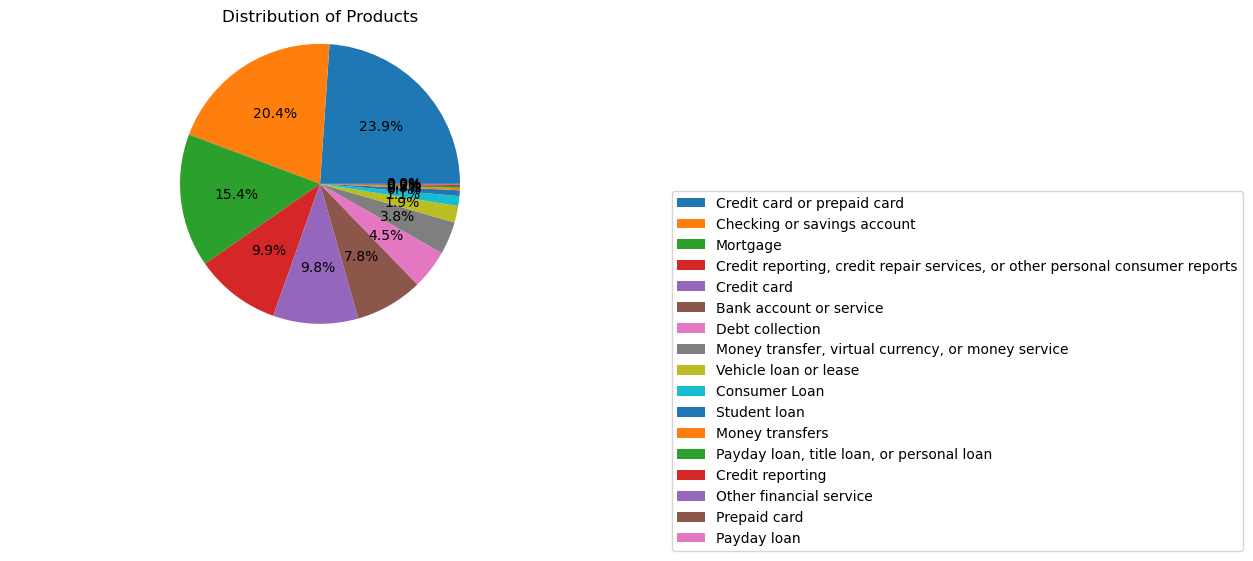

In [46]:

product_counts = filtered_df['product'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 4))
plt.pie(product_counts, labels=None, autopct='%1.1f%%')
plt.title('Distribution of Products')
plt.axis('equal')

# Create a legend for the pie chart
plt.legend(labels=product_counts.index, loc='upper right', bbox_to_anchor=(2, 0.5))

plt.show()

## Pre-Processing our Complaints text feature

In [71]:
rws = filtered_df.loc[:, ['product', 'complaint_what_happened']]

In [73]:
rws

,product,complaint_what_happened
1,Debt collection,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...
2,Credit card or prepaid card,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...
10,"Credit reporting, credit repair services, or other personal consumer reports","Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id..."
11,"Credit reporting, credit repair services, or other personal consumer reports","On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t..."
14,Checking or savings account,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...
...,...,...
78303,Credit card or prepaid card,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for..."
78309,Credit card or prepaid card,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to..."
78310,Checking or savings account,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...
78311,Credit card or prepaid card,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica..."


## Tokenizing Data

We'll use tokenizer library in order to split each individual word into a token. We will apply NLTK.word_tokenize() function to the “complaint_what_happened” column and create a new column named “tokenized”.

In [87]:
rws['tokenized'] = rws['complaint_what_happened'].apply(word_tokenize)
rws.head()

,product,complaint_what_happened,tokenized
1,Debt collection,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,"[Good, morning, my, name, is, XXXX, XXXX, and, I, appreciate, it, if, you, could, help, me, put,..."
2,Credit card or prepaid card,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,"[I, upgraded, my, XXXX, XXXX, card, in, XX/XX/2018, and, was, told, by, the, agent, who, did, th..."
10,"Credit reporting, credit repair services, or other personal consumer reports","Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...","[Chase, Card, was, reported, on, XX/XX/2019, ., However, ,, fraudulent, application, have, been,..."
11,"Credit reporting, credit repair services, or other personal consumer reports","On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...","[On, XX/XX/2018, ,, while, trying, to, book, a, XXXX, XXXX, ticket, ,, I, came, across, an, offe..."
14,Checking or savings account,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,"[my, grand, son, give, me, check, for, {, $, 1600.00, }, i, deposit, it, into, my, chase, accoun..."


## Converting all Characters to Lowercase
Transforming all words to lowercase is an important pre-processing step. In this case, we will once again append a new column named “lower” to the sliced dataframe which will transform all the tokenized words into lowercase. However, because we have to iterate over multiple words we will use a simple for-loop within a lambda function to apply the “lower” function to each word.

In [92]:
rws['lower'] = rws['tokenized'].apply(lambda x: [word.lower() for word in x])
rws.head()

,product,complaint_what_happened,tokenized,lower
1,Debt collection,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,"[Good, morning, my, name, is, XXXX, XXXX, and, I, appreciate, it, if, you, could, help, me, put,...","[good, morning, my, name, is, xxxx, xxxx, and, i, appreciate, it, if, you, could, help, me, put,..."
2,Credit card or prepaid card,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,"[I, upgraded, my, XXXX, XXXX, card, in, XX/XX/2018, and, was, told, by, the, agent, who, did, th...","[i, upgraded, my, xxxx, xxxx, card, in, xx/xx/2018, and, was, told, by, the, agent, who, did, th..."
10,"Credit reporting, credit repair services, or other personal consumer reports","Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...","[Chase, Card, was, reported, on, XX/XX/2019, ., However, ,, fraudulent, application, have, been,...","[chase, card, was, reported, on, xx/xx/2019, ., however, ,, fraudulent, application, have, been,..."
11,"Credit reporting, credit repair services, or other personal consumer reports","On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...","[On, XX/XX/2018, ,, while, trying, to, book, a, XXXX, XXXX, ticket, ,, I, came, across, an, offe...","[on, xx/xx/2018, ,, while, trying, to, book, a, xxxx, xxxx, ticket, ,, i, came, across, an, offe..."
14,Checking or savings account,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,"[my, grand, son, give, me, check, for, {, $, 1600.00, }, i, deposit, it, into, my, chase, accoun...","[my, grand, son, give, me, check, for, {, $, 1600.00, }, i, deposit, it, into, my, chase, accoun..."


## Removing Punctuations
Punctuation is often removed from our corpus since they serve little value once we begin to analyze our data. Continuing the previous pattern, we will create a new column which has the punctuation removed. We will again utilize a for-loop within a lambda function to iterate over the tokens but this time using an IF condition to only output alpha characters. It might be a little difficult to see but the tokenized punctuations in the “ lower” column has been removed.

In [96]:
punc = string.punctuation
rws['no_punc'] = rws['lower'].apply(lambda x: [word for word in x if word not in punc])
rws.head()

,product,complaint_what_happened,tokenized,lower,no_punc
1,Debt collection,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,"[Good, morning, my, name, is, XXXX, XXXX, and, I, appreciate, it, if, you, could, help, me, put,...","[good, morning, my, name, is, xxxx, xxxx, and, i, appreciate, it, if, you, could, help, me, put,...","[good, morning, my, name, is, xxxx, xxxx, and, i, appreciate, it, if, you, could, help, me, put,..."
2,Credit card or prepaid card,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,"[I, upgraded, my, XXXX, XXXX, card, in, XX/XX/2018, and, was, told, by, the, agent, who, did, th...","[i, upgraded, my, xxxx, xxxx, card, in, xx/xx/2018, and, was, told, by, the, agent, who, did, th...","[i, upgraded, my, xxxx, xxxx, card, in, xx/xx/2018, and, was, told, by, the, agent, who, did, th..."
10,"Credit reporting, credit repair services, or other personal consumer reports","Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...","[Chase, Card, was, reported, on, XX/XX/2019, ., However, ,, fraudulent, application, have, been,...","[chase, card, was, reported, on, xx/xx/2019, ., however, ,, fraudulent, application, have, been,...","[chase, card, was, reported, on, xx/xx/2019, however, fraudulent, application, have, been, submi..."
11,"Credit reporting, credit repair services, or other personal consumer reports","On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...","[On, XX/XX/2018, ,, while, trying, to, book, a, XXXX, XXXX, ticket, ,, I, came, across, an, offe...","[on, xx/xx/2018, ,, while, trying, to, book, a, xxxx, xxxx, ticket, ,, i, came, across, an, offe...","[on, xx/xx/2018, while, trying, to, book, a, xxxx, xxxx, ticket, i, came, across, an, offer, for..."
14,Checking or savings account,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,"[my, grand, son, give, me, check, for, {, $, 1600.00, }, i, deposit, it, into, my, chase, accoun...","[my, grand, son, give, me, check, for, {, $, 1600.00, }, i, deposit, it, into, my, chase, accoun...","[my, grand, son, give, me, check, for, 1600.00, i, deposit, it, into, my, chase, account, after,..."


## Removing Stopwords
Stopwords are typically useless words and do not add much meaning to a sentence. In the English language common stopwords include “you, he, she, in, a, has, are, etc.”

We are going to add a new column “no_stopwords” which will remove the stopwords from the “no_punc” column since it has been tokenized, had been converted to lowercase and punctuation was removed


In [99]:
stop_words = set(stopwords.words('english'))
rws['stopwords_removed'] = rws['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
rws.head()


,product,complaint_what_happened,tokenized,lower,no_punc,stopwords_removed
1,Debt collection,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,"[Good, morning, my, name, is, XXXX, XXXX, and, I, appreciate, it, if, you, could, help, me, put,...","[good, morning, my, name, is, xxxx, xxxx, and, i, appreciate, it, if, you, could, help, me, put,...","[good, morning, my, name, is, xxxx, xxxx, and, i, appreciate, it, if, you, could, help, me, put,...","[good, morning, name, xxxx, xxxx, appreciate, could, help, put, stop, chase, bank, cardmember, s..."
2,Credit card or prepaid card,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,"[I, upgraded, my, XXXX, XXXX, card, in, XX/XX/2018, and, was, told, by, the, agent, who, did, th...","[i, upgraded, my, xxxx, xxxx, card, in, xx/xx/2018, and, was, told, by, the, agent, who, did, th...","[i, upgraded, my, xxxx, xxxx, card, in, xx/xx/2018, and, was, told, by, the, agent, who, did, th...","[upgraded, xxxx, xxxx, card, xx/xx/2018, told, agent, upgrade, anniversary, date, would, change,..."
10,"Credit reporting, credit repair services, or other personal consumer reports","Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...","[Chase, Card, was, reported, on, XX/XX/2019, ., However, ,, fraudulent, application, have, been,...","[chase, card, was, reported, on, xx/xx/2019, ., however, ,, fraudulent, application, have, been,...","[chase, card, was, reported, on, xx/xx/2019, however, fraudulent, application, have, been, submi...","[chase, card, reported, xx/xx/2019, however, fraudulent, application, submitted, identity, witho..."
11,"Credit reporting, credit repair services, or other personal consumer reports","On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...","[On, XX/XX/2018, ,, while, trying, to, book, a, XXXX, XXXX, ticket, ,, I, came, across, an, offe...","[on, xx/xx/2018, ,, while, trying, to, book, a, xxxx, xxxx, ticket, ,, i, came, across, an, offe...","[on, xx/xx/2018, while, trying, to, book, a, xxxx, xxxx, ticket, i, came, across, an, offer, for...","[xx/xx/2018, trying, book, xxxx, xxxx, ticket, came, across, offer, 300.00, applied, towards, ti..."
14,Checking or savings account,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,"[my, grand, son, give, me, check, for, {, $, 1600.00, }, i, deposit, it, into, my, chase, accoun...","[my, grand, son, give, me, check, for, {, $, 1600.00, }, i, deposit, it, into, my, chase, accoun...","[my, grand, son, give, me, check, for, 1600.00, i, deposit, it, into, my, chase, account, after,...","[grand, son, give, check, 1600.00, deposit, chase, account, fund, clear, chase, bank, closed, ac..."
